In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

from resnet import ResNet, ResNet50

In [3]:
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=False)
len(cifar100)

50000

In [4]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [5]:
gen1 = torch.Generator().manual_seed(3)
corruption_idx = torch.randperm(len(cifar100), generator=gen1)[:20000]
corruption_idx = set(corruption_idx.numpy())

In [6]:
corruption_idx

{np.int64(5),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(13),
 np.int64(17),
 np.int64(20),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(31),
 np.int64(33),
 np.int64(34),
 np.int64(36),
 np.int64(39),
 np.int64(43),
 np.int64(44),
 np.int64(48),
 np.int64(50),
 np.int64(51),
 np.int64(52),
 np.int64(58),
 np.int64(59),
 np.int64(61),
 np.int64(65),
 np.int64(67),
 np.int64(68),
 np.int64(69),
 np.int64(71),
 np.int64(73),
 np.int64(76),
 np.int64(77),
 np.int64(78),
 np.int64(80),
 np.int64(81),
 np.int64(87),
 np.int64(89),
 np.int64(90),
 np.int64(91),
 np.int64(93),
 np.int64(103),
 np.int64(105),
 np.int64(106),
 np.int64(107),
 np.int64(108),
 np.int64(110),
 np.int64(111),
 np.int64(116),
 np.int64(118),
 np.int64(121),
 np.int64(122),
 np.int64(124),
 np.int64(125),
 np.int64(126),
 np.int64(128),
 np.int64(129),
 np.int64(133),
 np.int64(137),
 np.int64(139),
 np.int64(142),
 np.int64(146),
 np.int64(149),
 np.int64(150),
 np.int64(152),
 np.

In [9]:
from torch.utils.data import Dataset

In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
class CorruptedDataset(Dataset):
    def __init__(self, base_dataset, transforms=None, corruption=None, corrupt_idx=None):
        self.dataset = base_dataset
        self.transforms = transforms
        self.corruption = corruption
        self.corrupt_idx = corrupt_idx
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if self.transforms is not None:
            img = self.transforms(img)

        if idx not in self.corrupt_idx:
            return img, label
        else:
            img = self.corruption(img)
            return img, label

In [12]:
class Zero(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, img):
        return torch.zeros_like(img)

In [7]:
no_random_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
import pandas as pd

In [22]:
def load_scores_from_dir(score_dir):
    scores = pd.DataFrame()
    for i in range(10):
        score_path = f'./curv_scores/{score_dir}/epoch_{(i+1)*10}_scores.pt'
        scores[f'Epoch {(i+1) * 10}'] = torch.load(score_path, weights_only=True).numpy()
    scores['Mean Score'] = scores.mean(axis=1)
    return scores

In [24]:
standard_scores = load_scores_from_dir('standard')
standard_scores.head()

,Epoch 10,Epoch 20,Epoch 30,Epoch 40,Epoch 50,Epoch 60,Epoch 70,Epoch 80,Epoch 90,Epoch 100,Mean Score
0,0.001198,0.002767,0.002257,2.716511e-04,0.000500,4.745031e-05,2.769751e-06,1.356201e-05,6.619605e-07,2.108490e-06,0.000706
1,0.000088,0.000169,0.002194,2.010110e-05,0.000168,1.566408e-05,7.377089e-06,3.691190e-04,7.996465e-06,2.466044e-05,0.000306
2,0.002564,0.005078,0.002139,2.140652e-04,0.000031,3.053239e-04,1.300086e-05,8.371910e-05,1.152852e-05,2.562780e-05,0.001047
3,0.000841,0.000382,0.001281,4.719794e-04,0.000012,9.178214e-07,7.486442e-06,1.324775e-06,1.098776e-05,2.903399e-06,0.000301
4,0.000201,0.000423,0.000048,8.245681e-07,0.000093,6.276301e-05,5.742370e-08,4.166792e-08,7.862706e-07,5.731140e-09,0.000083


In [26]:
z05_scores = load_scores_from_dir('zero05')
z10_scores = load_scores_from_dir('zero10')
z20_scores = load_scores_from_dir('zero20')
z40_scores = load_scores_from_dir('zero40')

In [29]:
def remove_corruptions(df, corruption_idx):
    dropped = df.drop(corruption_idx)
    return dropped

dropped_standard = remove_corruptions(standard_scores, corruption_idx)
dropped_standard

,Epoch 10,Epoch 20,Epoch 30,Epoch 40,Epoch 50,Epoch 60,Epoch 70,Epoch 80,Epoch 90,Epoch 100,Mean Score
0,0.001198,0.002767,0.002257,2.716511e-04,0.000500,4.745031e-05,2.769751e-06,1.356201e-05,6.619605e-07,2.108490e-06,0.000706
1,0.000088,0.000169,0.002194,2.010110e-05,0.000168,1.566408e-05,7.377089e-06,3.691190e-04,7.996465e-06,2.466044e-05,0.000306
2,0.002564,0.005078,0.002139,2.140652e-04,0.000031,3.053239e-04,1.300086e-05,8.371910e-05,1.152852e-05,2.562780e-05,0.001047
3,0.000841,0.000382,0.001281,4.719794e-04,0.000012,9.178214e-07,7.486442e-06,1.324775e-06,1.098776e-05,2.903399e-06,0.000301
4,0.000201,0.000423,0.000048,8.245681e-07,0.000093,6.276301e-05,5.742370e-08,4.166792e-08,7.862706e-07,5.731140e-09,0.000083
...,...,...,...,...,...,...,...,...,...,...,...
49992,0.001206,0.000153,0.000326,1.207949e-05,0.000248,5.645301e-06,1.390489e-03,2.594033e-04,1.002296e-05,4.263548e-06,0.000362
49994,0.003227,0.004878,0.001192,3.527188e-04,0.002597,4.148428e-05,1.264663e-05,1.241668e-06,1.001321e-06,1.141358e-04,0.001242
49995,0.003139,0.004636,0.006875,5.839597e-03,0.001414,1.315119e-05,1.421922e-04,1.946994e-05,4.643975e-05,3.139690e-06,0.002213
49996,0.002818,0.001741,0.001967,1.084364e-03,0.000011,2.274449e-05,2.065889e-06,3.840591e-06,2.681444e-05,4.646985e-05,0.000772


In [34]:
dropped_z05 = remove_corruptions(z05_scores, corruption_idx)
dropped_z10 = remove_corruptions(z10_scores, corruption_idx)
dropped_z20 = remove_corruptions(z20_scores, corruption_idx)
dropped_z40 = remove_corruptions(z40_scores, corruption_idx)

In [35]:
dropped_df = pd.DataFrame({
    'standard': dropped_standard['Mean Score'],
    'z05': dropped_z05['Mean Score'],
    'z10': dropped_z10['Mean Score'],
    'z20': dropped_z20['Mean Score'],
    'z40': dropped_z40['Mean Score'],
})

dropped_df.head()

,standard,z05,z10,z20,z40
0,0.000706,0.000564,0.001139,0.000947,0.000700
1,0.000306,0.000088,0.000014,0.000132,0.000148
2,0.001047,0.000908,0.001785,0.000882,0.000461
3,0.000301,0.000452,0.000672,0.000244,0.000339
4,0.000083,0.000166,0.000868,0.000701,0.000275


In [48]:
dropped_df['diff05'] = dropped_df['z05'] - dropped_df['standard']
dropped_df['diff10'] = dropped_df['z10'] - dropped_df['standard']
dropped_df['diff20'] = dropped_df['z20'] - dropped_df['standard']
dropped_df['diff40'] = dropped_df['z40'] - dropped_df['standard']
dropped_df['total diff'] = dropped_df['z40'] - dropped_df['standard']
dropped_df.head()

,standard,z05,z10,z20,z40,diff05,diff10,diff20,diff40,total diff,std rank,z05 rank,z10 rank,z20 rank,z40 rank,total rank diff
0,0.000706,0.000564,0.001139,0.000947,0.000700,-0.000142,0.000433,0.000241,-0.000006,-0.000006,18572.0,21630.0,12751.0,16152.0,19640.0,1068.0
1,0.000306,0.000088,0.000014,0.000132,0.000148,-0.000219,-0.000292,-0.000175,-0.000159,-0.000159,25587.0,28944.0,29740.0,28570.0,28659.0,3072.0
2,0.001047,0.000908,0.001785,0.000882,0.000461,-0.000139,0.000738,-0.000165,-0.000585,-0.000585,13117.0,16089.0,6490.0,17167.0,23891.0,10774.0
3,0.000301,0.000452,0.000672,0.000244,0.000339,0.000151,0.000370,-0.000057,0.000038,0.000038,25670.0,23492.0,19606.0,27231.0,26010.0,340.0
4,0.000083,0.000166,0.000868,0.000701,0.000275,0.000083,0.000785,0.000618,0.000192,0.000192,28938.0,27862.0,16558.0,20152.0,26995.0,-1943.0


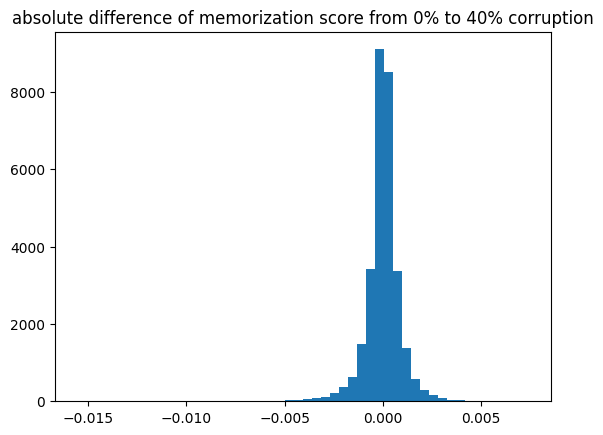

In [42]:
plt.hist(dropped_df['total diff'], bins=50)
plt.title('absolute difference of memorization score from 0% to 40% corruption')
plt.show()

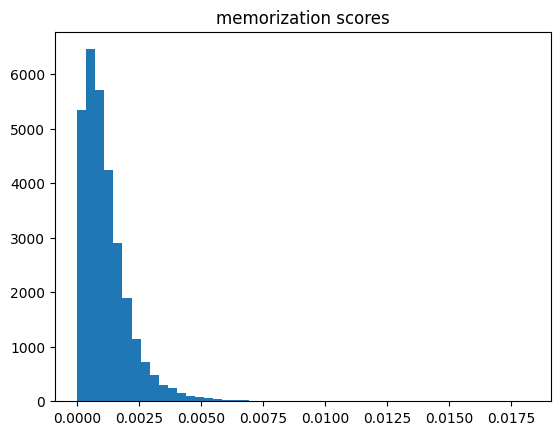

In [43]:
plt.hist(dropped_df['standard'], bins=50)
plt.title('memorization scores')
plt.show()

In [46]:
dropped_df['std rank'] = dropped_df['standard'].rank(ascending=False)
dropped_df['z05 rank'] = dropped_df['z05'].rank(ascending=False)
dropped_df['z10 rank'] = dropped_df['z10'].rank(ascending=False)
dropped_df['z20 rank'] = dropped_df['z20'].rank(ascending=False)
dropped_df['z40 rank'] = dropped_df['z40'].rank(ascending=False)
dropped_df.head()

,standard,z05,z10,z20,z40,diff05,diff10,diff20,diff40,total diff,std rank,z05 rank,z10 rank,z20 rank,z40 rank
0,0.000706,0.000564,0.001139,0.000947,0.000700,-0.000142,0.000575,-0.000192,-0.000247,-0.000006,18572.0,21630.0,12751.0,16152.0,19640.0
1,0.000306,0.000088,0.000014,0.000132,0.000148,-0.000219,-0.000073,0.000117,0.000016,-0.000159,25587.0,28944.0,29740.0,28570.0,28659.0
2,0.001047,0.000908,0.001785,0.000882,0.000461,-0.000139,0.000877,-0.000903,-0.000420,-0.000585,13117.0,16089.0,6490.0,17167.0,23891.0
3,0.000301,0.000452,0.000672,0.000244,0.000339,0.000151,0.000220,-0.000428,0.000096,0.000038,25670.0,23492.0,19606.0,27231.0,26010.0
4,0.000083,0.000166,0.000868,0.000701,0.000275,0.000083,0.000702,-0.000167,-0.000426,0.000192,28938.0,27862.0,16558.0,20152.0,26995.0


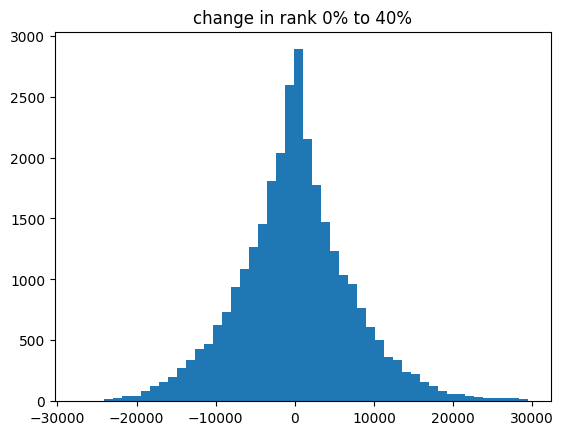

In [63]:
dropped_df['total rank diff'] = dropped_df['z40 rank'] - dropped_df['std rank']
plt.hist(dropped_df['total rank diff'], bins=50)
plt.title('change in rank 0% to 40%')
plt.show()

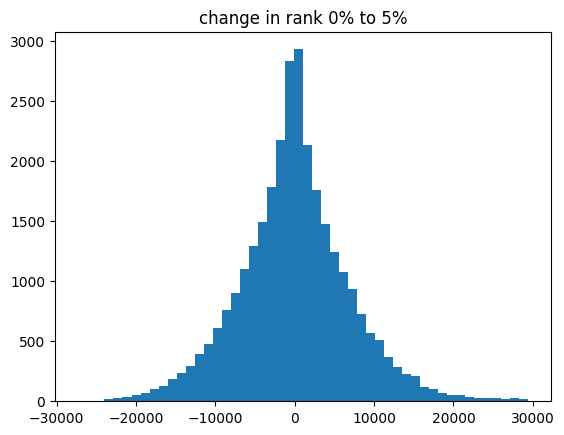

In [62]:
dropped_df['z05 rank diff'] = dropped_df['z05 rank'] - dropped_df['std rank']
plt.hist(dropped_df['z05 rank diff'], bins=50)
plt.title('change in rank 0% to 5%')
plt.show()

In [59]:
def spearman(rankx, ranky):
    total = 0
    n = len(rankx)
    for i in range(n):
        total += (rankx[i] - ranky[i]) ** 2
    return 1 - 6 * total / (n * (n ** 2 - 1))

In [60]:
columns = ['std rank', 'z05 rank', 'z10 rank', 'z20 rank', 'z40 rank']
n = len(columns)
sp_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sp_matrix[i, j] = spearman(dropped_df[columns[i]].to_numpy(), dropped_df[columns[j]].to_numpy())

In [61]:
sp_matrix

array([[1.        , 0.67265982, 0.67056139, 0.64992214, 0.64878255],
       [0.67265982, 1.        , 0.71331589, 0.69095618, 0.69076416],
       [0.67056139, 0.71331589, 1.        , 0.69692598, 0.70336774],
       [0.64992214, 0.69095618, 0.69692598, 1.        , 0.68382188],
       [0.64878255, 0.69076416, 0.70336774, 0.68382188, 1.        ]])

In [66]:
dropped_df.head()

,standard,z05,z10,z20,z40,diff05,diff10,diff20,diff40,total diff,std rank,z05 rank,z10 rank,z20 rank,z40 rank,total rank diff,z05 rank diff
0,0.000706,0.000564,0.001139,0.000947,0.000700,-0.000142,0.000433,0.000241,-0.000006,-0.000006,18572.0,21630.0,12751.0,16152.0,19640.0,1068.0,3058.0
1,0.000306,0.000088,0.000014,0.000132,0.000148,-0.000219,-0.000292,-0.000175,-0.000159,-0.000159,25587.0,28944.0,29740.0,28570.0,28659.0,3072.0,3357.0
2,0.001047,0.000908,0.001785,0.000882,0.000461,-0.000139,0.000738,-0.000165,-0.000585,-0.000585,13117.0,16089.0,6490.0,17167.0,23891.0,10774.0,2972.0
3,0.000301,0.000452,0.000672,0.000244,0.000339,0.000151,0.000370,-0.000057,0.000038,0.000038,25670.0,23492.0,19606.0,27231.0,26010.0,340.0,-2178.0
4,0.000083,0.000166,0.000868,0.000701,0.000275,0.000083,0.000785,0.000618,0.000192,0.000192,28938.0,27862.0,16558.0,20152.0,26995.0,-1943.0,-1076.0


In [70]:
big_diff = dropped_df[abs(dropped_df['total rank diff']) > 10000]
big_diff

,standard,z05,z10,z20,z40,diff05,diff10,diff20,diff40,total diff,std rank,z05 rank,z10 rank,z20 rank,z40 rank,total rank diff,z05 rank diff
2,0.001047,0.000908,0.001785,0.000882,0.000461,-0.000139,0.000738,-0.000165,-0.000585,-0.000585,13117.0,16089.0,6490.0,17167.0,23891.0,10774.0,2972.0
7,0.002309,0.000456,0.000559,0.000526,0.000218,-0.001854,-0.001750,-0.001783,-0.002092,-0.002092,2994.0,23417.0,21480.0,22997.0,27797.0,24803.0,20423.0
22,0.001611,0.000684,0.001113,0.000627,0.000821,-0.000927,-0.000498,-0.000983,-0.000790,-0.000790,6823.0,19634.0,13113.0,21387.0,17533.0,10710.0,12811.0
29,0.002581,0.003110,0.003805,0.002175,0.001078,0.000529,0.001224,-0.000406,-0.001503,-0.001503,2218.0,1598.0,737.0,4283.0,13277.0,11059.0,-620.0
37,0.000730,0.000984,0.001434,0.001499,0.002131,0.000254,0.000705,0.000770,0.001401,0.001401,18175.0,15001.0,9456.0,9103.0,3705.0,-14470.0,-3174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49974,0.001234,0.001244,0.000831,0.000992,0.000414,0.000009,-0.000403,-0.000242,-0.000820,-0.000820,10637.0,11556.0,17134.0,15416.0,24704.0,14067.0,919.0
49982,0.000188,0.000270,0.000573,0.000399,0.001284,0.000082,0.000385,0.000211,0.001096,0.001096,27484.0,26319.0,21259.0,25076.0,10468.0,-17016.0,-1165.0
49990,0.001014,0.000256,0.000523,0.000912,0.000451,-0.000759,-0.000491,-0.000102,-0.000563,-0.000563,13572.0,26563.0,22091.0,16682.0,24083.0,10511.0,12991.0
49995,0.002213,0.001871,0.001967,0.001196,0.000795,-0.000341,-0.000246,-0.001017,-0.001418,-0.001418,3330.0,5999.0,5326.0,12603.0,18032.0,14702.0,2669.0


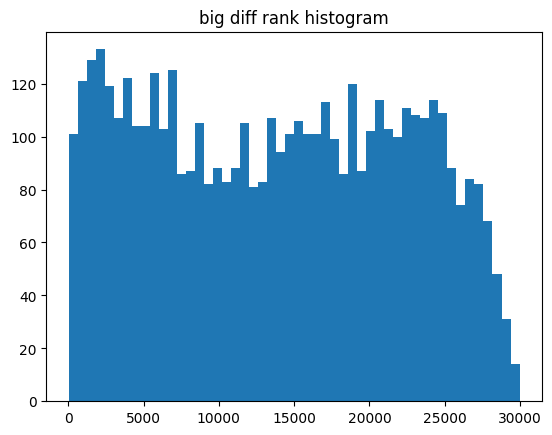

In [73]:
plt.hist(big_diff['std rank'], bins=50)
plt.title('big diff rank histogram')
plt.show()